In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt 
%matplotlib inline

In [2]:
df = pd.read_csv('data/cc_data_processed.csv')

In [3]:
# Use date as index
df.index = pd.to_datetime(df['Transaction Date'])
df.drop('Transaction Date', axis = 1, inplace = True, errors='ignore')
df.head()

,Account Type,Consumer Gender,Normalized Retailer,SIC Description,Purchase Amount,Age
Transaction Date,,,,,,
2019-07-01,credit_card,male,Red Robin,Eating Places,15.52,22.0
2019-09-30,bank_account,male,California Thai,Eating Places,11.29,30.0
2019-06-24,credit_card,male,Petro-Canada,Gasoline Service Stations,10.78,34.0
2018-10-01,bank_account,female,The Beer Store,Other,88.90,43.0
2019-12-01,bank_account,male,Intermarche,Grocery Stores,23.54,62.0


In [4]:
# table with transaction counts and total amount aggregated for each month
df_group = df.groupby([pd.Grouper(freq = 'M')]).agg({'Purchase Amount': {'count', 'sum'}})
df_group.columns = ['Purchase_Sum','Transaction_Count']
df_group.head()

,Purchase_Sum,Transaction_Count
Transaction Date,,
2016-04-30,12,103.81
2016-05-31,31,967.50
2016-06-30,48,1346.28
2016-07-31,58,1645.19
2016-08-31,88,2971.88


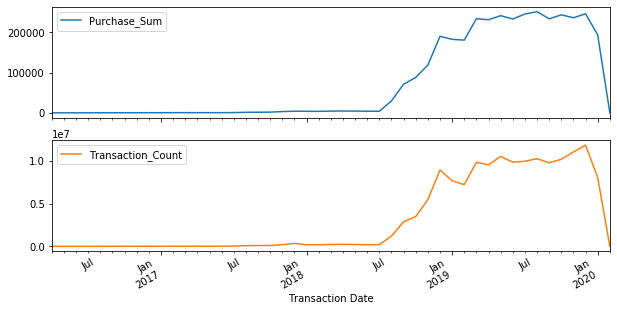

In [5]:
df_group.plot(subplots = True, y= ["Purchase_Sum","Transaction_Count"], figsize=(10,5));

                  Purchase_Sum  Transaction_Count
Transaction Date                                 
2018-09-30               70906       2.864154e+06
2018-10-31               87826       3.476955e+06
2018-11-30              118630       5.455445e+06
2018-12-31              189849       8.910758e+06
2019-01-31              182379       7.653694e+06
2019-02-28              180404       7.199211e+06
2019-03-31              233468       9.809226e+06
2019-04-30              230990       9.517425e+06
2019-05-31              241047       1.049074e+07
2019-06-30              232827       9.825952e+06
2019-07-31              245095       9.930230e+06
2019-08-31              250985       1.023078e+07
2019-09-30              233238       9.750168e+06
2019-10-31              243126       1.016536e+07
2019-11-30              235863       1.101461e+07
2019-12-31              245742       1.180695e+07
2020-01-31              193349       8.032002e+06


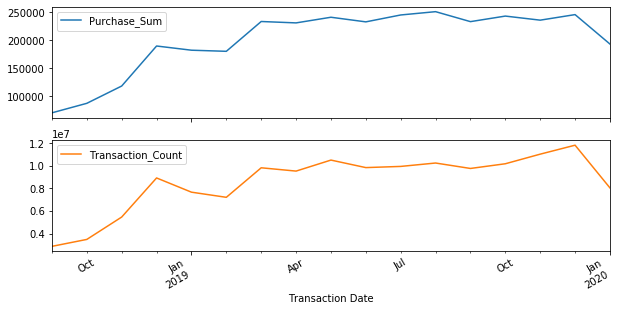

In [6]:
# only keep data from Sep 2018 to Jan 2020
df_period = df_group.loc['2018-09-01':'2020-01-31']
df_period.plot(subplots = True, y= ["Purchase_Sum","Transaction_Count"], figsize=(10,5));
print(df_period) # 17 month in total

In [7]:
# load marco economic data
df_eco = pd.read_csv('data/eco/macro_economic_data.csv')

# Extract eco data from Sep 2018 to Jan 2020
df_eco.index = pd.to_datetime(df_eco['Date'])
df_eco.drop('Date',axis = 1, inplace = True, errors='ignore')
df_eco = df_eco.loc['2018-09-01':'2020-01-31']

print(df_eco)

              CPI  Exchange_Rate_USD        GDP  Unemployment_Rate        TSX
Date                                                                         
2018-09-01  133.7             1.3037  1,948,264                5.4  16,073.14
2018-10-01  134.1             1.3010  1,951,927                5.3  15,027.28
2018-11-01  133.5             1.3200  1,947,407                5.2  15,197.82
2018-12-01  133.4             1.3432  1,947,565                5.2  14,322.86
2019-01-01  133.6             1.3301  1,950,566                6.2  15,540.60
2019-02-01  134.5             1.3206  1,947,014                6.1  15,999.01
2019-03-01  135.4             1.3368  1,959,450                6.2  16,102.09
2019-04-01  136.0             1.3378  1,965,660                5.9  16,580.73
2019-05-01  136.6             1.3459  1,971,646                5.5  16,037.49
2019-06-01  136.3             1.3287  1,975,775                5.2  16,382.20
2019-07-01  137.0             1.3101  1,976,884                5

In [11]:
df_all = pd.concat([df_eco, df_period.set_index(df_eco.index)], axis=1)
df_all.head(20)

,CPI,Exchange_Rate_USD,GDP,Unemployment_Rate,TSX,Purchase_Sum,Transaction_Count
Date,,,,,,,
2018-09-01,133.7,1.3037,"1,948,264",5.4,"16,073.14",70906,2.864154e+06
2018-10-01,134.1,1.3010,"1,951,927",5.3,"15,027.28",87826,3.476955e+06
2018-11-01,133.5,1.3200,"1,947,407",5.2,"15,197.82",118630,5.455445e+06
2018-12-01,133.4,1.3432,"1,947,565",5.2,"14,322.86",189849,8.910758e+06
2019-01-01,133.6,1.3301,"1,950,566",6.2,"15,540.60",182379,7.653694e+06
2019-02-01,134.5,1.3206,"1,947,014",6.1,"15,999.01",180404,7.199211e+06
2019-03-01,135.4,1.3368,"1,959,450",6.2,"16,102.09",233468,9.809226e+06
2019-04-01,136.0,1.3378,"1,965,660",5.9,"16,580.73",230990,9.517425e+06
2019-05-01,136.6,1.3459,"1,971,646",5.5,"16,037.49",241047,1.049074e+07


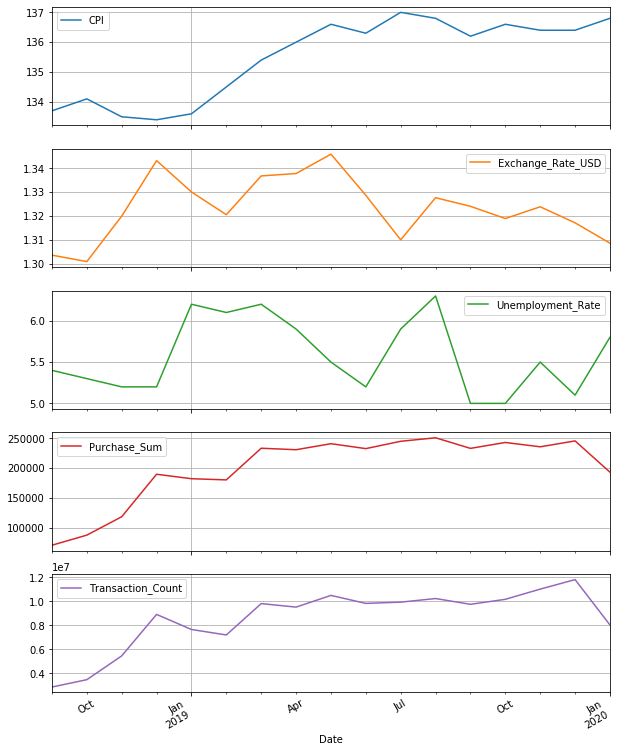

In [15]:
df_all.plot(subplots = True, figsize=(10,14));